# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**
### Tecnológico de Monterrey
### Prof.: Dra. Grettel Barceló

## **Actividad Semana 5**

### **Baseline**

##### Nombres y matrículas de los integrantes del equipo:
*   Omar Juárez Téllez - A01795499
*   Victoria Melgarejo Cabrera - A01795030
*   Julio Cesar Mestas - A01794827

---


#### **Objetivo de la Actividad:**

3.1 Establecer las medidas de calidad del modelo de aprendizaje automático.

3.2 Proporcionar un marco de referencia para evaluar y mejorar modelos más avanzados.


---

## **1. Importación de Librerías**

In [5]:
!pip install -q sentence-transformers transformers accelerate unidecode
!pip install -q regex
!pip -q install imbalanced-learn xgboost
!pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.3 MB/s eta 0:00:00


In [6]:
import io
import os
import gc
import math
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import stats
from pandas.tseries.offsets import MonthBegin
import re
#from unidecode import unidecode
import unicodedata
from collections import defaultdict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    precision_recall_curve, roc_curve
)
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pathlib import Path
from itertools import islice

from IPython.display import display
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import OneHotEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
pd.set_option("display.max_colwidth", 200)

# Configuración visual
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# Carpeta de salida
OUTPUT_DIR = "./eda_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## **2. Carga de Datos**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2.1 Preparación del Entorno y Lectura del Dataset**

In [7]:
# Ruta base donde están los archivos
# base_path = "/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 4/Resultados/"
base_path = "/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 5/Resultados/"

In [13]:
# Nombre del archivo
file_name_train = "PROCESAMIENTO_DATA_TRAIN.xlsx"
file_name_val = "PROCESAMIENTO_DATA_VAL.xlsx"
file_name_test = "PROCESAMIENTO_DATA_TEST.xlsx"

# Lectura del archivo CSV
df_mastertable_train = pd.read_excel(f"{base_path}/{file_name_train}")
df_mastertable_val = pd.read_excel(f"{base_path}/{file_name_val}")
df_mastertable_test = pd.read_excel(f"{base_path}/{file_name_test}")

In [15]:
# Validamos la correcta carga de los dataset
rows1, cols1 = df_mastertable_train.shape
rows2, cols2 = df_mastertable_val.shape
rows3, cols3 = df_mastertable_test.shape

print(f"Dimensiones Train: {rows1:,} filas × {cols1:,} columnas")
print(f"Dimensiones Val: {rows2:,} filas × {cols2:,} columnas")
print(f"Dimensiones Test: {rows3:,} filas × {cols3:,} columnas")

print("\nTipos de datos train (por columna):")
print(df_mastertable_train.dtypes)
print("\nResumen de tipos train (conteo por dtype):")
print(df_mastertable_train.dtypes.value_counts())
print("\nPrimeras 3 filas train:")
display(df_mastertable_train.head(3))

Dimensiones Train: 1,678 filas × 76 columnas
Dimensiones Val: 475 filas × 76 columnas
Dimensiones Test: 706 filas × 76 columnas

Tipos de datos train (por columna):
Unnamed: 0                        int64
ID_EHT                           object
FECHA_MES_5                      object
CODMES                            int64
target_hosp_15d                   int64
                                 ...   
kw_dm_w30d                      float64
rx_antidiabeticos_w30d_yj       float64
rx_antihipertensivos_w30d_yj    float64
kw_dm_w30d_sqrt                 float64
kw_dolor_w30d_sqrt              float64
Length: 76, dtype: object

Resumen de tipos train (conteo por dtype):
float64    60
int64      14
object      2
Name: count, dtype: int64

Primeras 3 filas train:


,Unnamed: 0,ID_EHT,FECHA_MES_5,CODMES,target_hosp_15d,target_hosp_21d,target_hosp_30d,target_hosp_90d,GENERO_bin,REGION_REGION_Bajío,REGION_REGION_Centro,REGION_REGION_Norte,REGION_REGION_Occidente,REGION_REGION_Otros,REGION_REGION_Sur,rx_polifarmacia_30d,ACIDO_URICO,ALBUMINA,ALBUMINA_EN_SUERO,BILIRRUBINA_DIRECTA,BILIRRUBINA_INDIRECTA,BILIRRUBINA_TOTAL,CALCIO,COLESTEROL_HDL,COLESTEROL_LDL,COLESTEROL_TOTAL,COLESTEROL_VLDL,CREATININA_SERICA,DENSIDAD,DESHIDROGENASA_LACTICA,ERITROCITOS,FOSFATA_ALCALINA,FOSFORO,GLOBULINA,GLUCOSA_EN_SUERO_AYUNO,HEMATOCRITOS,HEMOGLOBINA,HEMOGLOBINA_GLUCOSILADA_HBA1C,HIERRO,IMC,INDICE_ATEROGENICO,LEUCOCITOS_TOTALES,NITROGENO_UREICO_BUN,OXIMETRIA_CAPILAR,PESO,PH,PLAQUETAS,POTASIO,PROTEINA_C_REACTIVA,PROTEINA_TOTAL,SODIO,TALLA,TENSION_ARTERIAL_SISTOLICA,TRIGLICERIDOS,TENSION_ARTERIAL_DIASTOLICA,DIAS_EN_PROGRAMA,EDAD,rx_w30d,rx_meds_unicos_30d,rx_consultas_30d,rx_estatinas_w30d,rx_antibioticos_w30d,rx_antihipertensivos_w30d,rx_antidiabeticos_w30d,notas_w30d,tokens_notas_w30d,kw_adherencia_w30d,kw_infeccion_w30d,kw_fiebre_w30d,kw_htn_w30d,kw_dolor_w30d,kw_dm_w30d,rx_antidiabeticos_w30d_yj,rx_antihipertensivos_w30d_yj,kw_dm_w30d_sqrt,kw_dolor_w30d_sqrt
0,0,Csalinas2265705,2024-06-05,202406,0,0,0,0,1,0,0,1,0,0,0,1,-0.077329,0.005625,0.003087,-0.177186,-0.146291,-0.144848,0.084269,-0.061462,-0.053537,-0.07348,-0.028814,-0.137253,-0.049052,-0.034158,0.018967,-0.058678,-0.065797,-0.071198,-0.17259,-0.0261,-0.020352,-0.110335,-0.024358,-0.063122,-0.118778,-0.074698,-0.157151,0.062623,-0.0447,-0.193866,-0.088004,-0.088087,-0.111451,-0.035961,0.093032,-0.01023,-0.063381,-0.167936,0.070342,-1.609348,-0.536256,-0.286687,0.004153,-0.428608,-0.357183,-0.028364,-0.35359,-0.329965,-0.318857,-0.0941,-0.068388,-0.247061,-0.101226,-0.446985,-0.340049,-0.479103,-0.53208,-0.564747,-0.610283,-0.448463
1,1,Csalinas2265705,2024-07-05,202407,0,0,0,0,1,0,0,1,0,0,0,1,-0.077329,0.005625,0.003087,-0.177186,-0.146291,-0.144848,0.084269,-0.061462,-0.053537,-0.07348,-0.028814,-0.137253,-0.049052,-0.034158,0.018967,-0.058678,-0.065797,-0.071198,-0.17259,-0.0261,-0.020352,-0.110335,-0.024358,-0.063122,-0.118778,-0.074698,-0.157151,0.062623,-0.0447,-0.193866,-0.088004,-0.088087,-0.111451,-0.035961,0.093032,-0.01023,-0.063381,-0.167936,0.070342,-1.447313,-0.469661,-0.286687,0.004153,-0.428608,-0.357183,-0.028364,-0.35359,-0.329965,-0.318857,-0.0941,-0.068388,-0.247061,-0.101226,-0.446985,-0.340049,-0.479103,-0.53208,-0.564747,-0.610283,-0.448463
2,2,Csalinas2265705,2024-08-05,202408,0,0,0,0,1,0,0,1,0,0,0,1,-0.077329,0.005625,0.003087,-0.177186,-0.146291,-0.144848,0.084269,-0.061462,-0.053537,-0.07348,-0.028814,-0.137253,-0.049052,-0.034158,0.018967,-0.058678,-0.065797,-0.071198,-0.17259,-0.0261,-0.020352,-0.110335,-0.024358,-0.063122,-0.118778,-0.074698,-0.157151,0.062623,-0.0447,-0.193866,-0.088004,-0.088087,-0.111451,-0.035961,0.093032,-0.01023,-0.063381,-0.167936,0.070342,-1.279877,-0.469661,-0.286687,0.004153,-0.428608,-0.357183,-0.028364,-0.35359,-0.329965,-0.318857,-0.0941,-0.068388,-0.247061,-0.101226,-0.446985,-0.340049,-0.479103,-0.53208,-0.564747,-0.610283,-0.448463


**2.2 Inferencia de Tipos y Fechas (limpieza ligera)**

In [16]:
# --- Poblacion ---
df_mastertable_train["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_train["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

df_mastertable_val["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_val["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

df_mastertable_test["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_test["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

In [17]:
df_mastertable_train[df_mastertable_train['ID_EHT'] == 'vpoot2336437']

,Unnamed: 0,ID_EHT,FECHA_MES_5,CODMES,target_hosp_15d,target_hosp_21d,target_hosp_30d,target_hosp_90d,GENERO_bin,REGION_REGION_Bajío,REGION_REGION_Centro,REGION_REGION_Norte,REGION_REGION_Occidente,REGION_REGION_Otros,REGION_REGION_Sur,rx_polifarmacia_30d,ACIDO_URICO,ALBUMINA,ALBUMINA_EN_SUERO,BILIRRUBINA_DIRECTA,BILIRRUBINA_INDIRECTA,BILIRRUBINA_TOTAL,CALCIO,COLESTEROL_HDL,COLESTEROL_LDL,COLESTEROL_TOTAL,COLESTEROL_VLDL,CREATININA_SERICA,DENSIDAD,DESHIDROGENASA_LACTICA,ERITROCITOS,FOSFATA_ALCALINA,FOSFORO,GLOBULINA,GLUCOSA_EN_SUERO_AYUNO,HEMATOCRITOS,HEMOGLOBINA,HEMOGLOBINA_GLUCOSILADA_HBA1C,HIERRO,IMC,INDICE_ATEROGENICO,LEUCOCITOS_TOTALES,NITROGENO_UREICO_BUN,OXIMETRIA_CAPILAR,PESO,PH,PLAQUETAS,POTASIO,PROTEINA_C_REACTIVA,PROTEINA_TOTAL,SODIO,TALLA,TENSION_ARTERIAL_SISTOLICA,TRIGLICERIDOS,TENSION_ARTERIAL_DIASTOLICA,DIAS_EN_PROGRAMA,EDAD,rx_w30d,rx_meds_unicos_30d,rx_consultas_30d,rx_estatinas_w30d,rx_antibioticos_w30d,rx_antihipertensivos_w30d,rx_antidiabeticos_w30d,notas_w30d,tokens_notas_w30d,kw_adherencia_w30d,kw_infeccion_w30d,kw_fiebre_w30d,kw_htn_w30d,kw_dolor_w30d,kw_dm_w30d,rx_antidiabeticos_w30d_yj,rx_antihipertensivos_w30d_yj,kw_dm_w30d_sqrt,kw_dolor_w30d_sqrt
1668,2844,vpoot2336437,2024-09-05,202409,0,0,0,0,0,0,0,0,0,0,1,0,-0.077329,0.005625,0.003087,-0.177186,-0.146291,-0.144848,0.084269,-0.061462,-0.053537,-0.07348,-0.028814,-0.137253,-0.049052,-0.034158,0.018967,-0.058678,-0.065797,-0.071198,1.083006,-0.0261,-0.020352,-0.110335,-0.024358,1.333130,-0.118778,-0.074698,-0.157151,0.062623,0.271397,-0.193866,-0.088004,-0.088087,-0.111451,-0.035961,0.093032,-1.600129,-0.063381,-0.167936,0.710281,-1.539133,-0.469661,0.193111,-0.460475,1.009800,1.164635,-0.028364,0.886177,0.636142,0.772951,-1.018921,-0.068388,-0.247061,-0.101226,0.556142,-0.340049,0.806711,2.128164,2.113715,1.308926,-0.448463
1669,2845,vpoot2336437,2024-10-05,202410,0,0,0,0,0,0,0,0,0,0,1,1,-0.077329,0.005625,0.003087,-0.177186,-0.146291,-0.144848,0.084269,-0.061462,-0.053537,-0.07348,-0.028814,-0.137253,-0.049052,-0.034158,0.018967,-0.058678,-0.065797,-0.071198,0.779710,-0.0261,-0.020352,-0.110335,-0.024358,1.333130,-0.118778,-0.074698,-0.157151,0.062623,0.271397,-0.193866,-0.088004,-0.088087,-0.111451,-0.035961,0.093032,-1.600129,0.532369,-0.167936,0.710281,-1.377098,-0.469661,0.270964,0.004153,-0.428608,0.945283,-0.028364,1.795863,0.507532,0.102679,-0.811169,-0.068388,-0.247061,0.379833,0.269752,-0.340049,0.489295,2.068565,2.200670,1.055277,-0.448463
1670,2846,vpoot2336437,2024-11-05,202411,0,0,0,0,0,0,0,0,0,0,1,1,-0.077329,0.005625,0.003087,-0.177186,-0.146291,-0.144848,0.084269,-0.061462,-0.053537,-0.07348,-0.028814,-0.137253,-0.049052,-0.034158,0.018967,-0.058678,-0.065797,-0.071198,0.779710,-0.0261,-0.020352,-0.110335,-0.024358,-0.063122,-0.118778,-0.074698,-0.157151,0.062623,-0.044700,-0.193866,-0.088004,-0.088087,-0.111451,-0.035961,0.093032,-0.010230,-0.063381,-0.167936,0.070342,-1.209662,-0.469661,-0.286687,0.004153,-0.428608,-0.357183,-0.028364,-0.353590,-0.329965,-0.318857,-0.094100,-0.068388,-0.247061,-0.101226,-0.446985,-0.340049,-0.479103,-0.532080,-0.564747,-0.610283,-0.448463
1671,2847,vpoot2336437,2024-12-05,202412,0,0,0,0,0,0,0,0,0,0,1,1,-0.077329,0.005625,0.003087,-0.177186,-0.146291,-0.144848,0.084269,-0.061462,-0.053537,-0.07348,-0.028814,-0.137253,-0.049052,-0.034158,0.018967,-0.058678,-0.065797,-0.071198,0.628063,-0.0261,-0.020352,-0.110335,-0.024358,-0.063122,-0.118778,-0.074698,-0.157151,0.062623,-0.044700,-0.193866,-0.088004,-0.088087,-0.111451,-0.035961,0.093032,-0.010230,-0.063381,-0.167936,0.070342,-1.047628,-0.469661,-0.286687,0.004153,-0.428608,-0.357183,-0.028364,-0.353590,-0.329965,-0.318857,-0.094100,-0.068388,-0.247061,-0.101226,-0.446985,-0.340049,-0.479103,-0.532080,-0.564747,-0.610283,-0.448463


**2.3 Inspección Inicial de Variables**

In [18]:
# ================== Resumen rápido de esquema (usando vars_in) ==================
id_cols     = ["ID_EHT","FECHA_MES_5","CODMES"]
target_cols = ["target_hosp_15d","target_hosp_21d","target_hosp_30d","target_hosp_90d"]

vars_in = [
    "GENERO_bin","REGION_REGION_Bajío","REGION_REGION_Centro","REGION_REGION_Norte",
    "REGION_REGION_Occidente","REGION_REGION_Otros","REGION_REGION_Sur",
    "ACIDO_URICO","ALBUMINA","ALBUMINA_EN_SUERO","BILIRRUBINA_DIRECTA","BILIRRUBINA_INDIRECTA",
    "BILIRRUBINA_TOTAL","CALCIO","COLESTEROL_HDL","COLESTEROL_LDL","COLESTEROL_TOTAL","COLESTEROL_VLDL",
    "CREATININA_SERICA","DENSIDAD","DESHIDROGENASA_LACTICA","ERITROCITOS","FOSFATA_ALCALINA","FOSFORO",
    "GLOBULINA","GLUCOSA_EN_SUERO_AYUNO","HEMATOCRITOS","HEMOGLOBINA","HEMOGLOBINA_GLUCOSILADA_HBA1C",
    "HIERRO","IMC","INDICE_ATEROGENICO","LEUCOCITOS_TOTALES","NITROGENO_UREICO_BUN","OXIMETRIA_CAPILAR",
    "PESO","PH","PLAQUETAS","POTASIO","PROTEINA_C_REACTIVA","PROTEINA_TOTAL","SODIO","TALLA",
    "TENSION_ARTERIAL_SISTOLICA","TRIGLICERIDOS","TENSION_ARTERIAL_DIASTOLICA",
    "DIAS_EN_PROGRAMA","EDAD","rx_w30d","rx_meds_unicos_30d","rx_consultas_30d","rx_polifarmacia_30d",
    "rx_estatinas_w30d","rx_antibioticos_w30d","rx_antidiabeticos_w30d_yj","rx_antihipertensivos_w30d_yj",
    "notas_w30d","tokens_notas_w30d","kw_adherencia_w30d","kw_infeccion_w30d","kw_fiebre_w30d",
    "kw_htn_w30d","kw_dm_w30d_sqrt","kw_dolor_w30d_sqrt"
]

# 8 categóricas fijas:
categorical_fixed = [
    "GENERO_bin",
    "REGION_REGION_Bajío","REGION_REGION_Centro","REGION_REGION_Norte",
    "REGION_REGION_Occidente","REGION_REGION_Otros","REGION_REGION_Sur",
    "rx_polifarmacia_30d"
]

def quick_schema_report(df, name="DATASET"):
    cols = set(df.columns)
    targets_present = [t for t in target_cols if t in cols]
    feats_present   = [v for v in vars_in if v in cols]
    cat_present     = [c for c in categorical_fixed if c in cols]
    num_present     = [v for v in feats_present if v not in cat_present]
    missing_feats   = [v for v in vars_in if v not in cols]

    print(f"\n=== {name} ===")
    print(f"Targets presentes: {targets_present}  |  #targets={len(targets_present)}")
    print(f"#features (vars_in ∩ columnas) = {len(feats_present)}")
    print(f"  - Categóricas (fijas, esperadas=8): {len(cat_present)} -> {cat_present}")
    print(f"  - Numéricas: {len(num_present)}  (ej: {num_present[:8]})")
    if missing_feats:
        print(f"[Aviso] Variables de vars_in no encontradas en {name}: {missing_feats}")

# Ejecuta para tus tres splits
quick_schema_report(df_mastertable_train, "TRAIN")
quick_schema_report(df_mastertable_val,   "VALID")
quick_schema_report(df_mastertable_test,  "TEST")



=== TRAIN ===
Targets presentes: ['target_hosp_15d', 'target_hosp_21d', 'target_hosp_30d', 'target_hosp_90d']  |  #targets=4
#features (vars_in ∩ columnas) = 64
  - Categóricas (fijas, esperadas=8): 8 -> ['GENERO_bin', 'REGION_REGION_Bajío', 'REGION_REGION_Centro', 'REGION_REGION_Norte', 'REGION_REGION_Occidente', 'REGION_REGION_Otros', 'REGION_REGION_Sur', 'rx_polifarmacia_30d']
  - Numéricas: 56  (ej: ['ACIDO_URICO', 'ALBUMINA', 'ALBUMINA_EN_SUERO', 'BILIRRUBINA_DIRECTA', 'BILIRRUBINA_INDIRECTA', 'BILIRRUBINA_TOTAL', 'CALCIO', 'COLESTEROL_HDL'])

=== VALID ===
Targets presentes: ['target_hosp_15d', 'target_hosp_21d', 'target_hosp_30d', 'target_hosp_90d']  |  #targets=4
#features (vars_in ∩ columnas) = 64
  - Categóricas (fijas, esperadas=8): 8 -> ['GENERO_bin', 'REGION_REGION_Bajío', 'REGION_REGION_Centro', 'REGION_REGION_Norte', 'REGION_REGION_Occidente', 'REGION_REGION_Otros', 'REGION_REGION_Sur', 'rx_polifarmacia_30d']
  - Numéricas: 56  (ej: ['ACIDO_URICO', 'ALBUMINA', 'ALBUMINA

## **3. Entrenamiento de Modelo Baseline**

Este capítulo presenta el proceso de entrenamiento y evaluación del modelo de referencia para la predicción de hospitalizaciones a 30 y 90 días. La sección se organiza en dos subapartados: 3.1 Baseline para 30 días y 3.2 Baseline para 90 días. Antes de detallar cada caso, se sintetizan las decisiones metodológicas, las exploraciones preliminares y el protocolo experimental adoptado.

En una primera etapa se entrenó un baseline lineal mediante Regresión Logística (RL) con regularización L2 y ponderación de clases para mitigar el desbalance. La RL se eligió por su interpretabilidad y porque constituye el estándar mínimo de comparación en problemas de riesgo clínico. Sin embargo, al evaluar con validación temporal (entrenar en meses previos y validar en meses futuros), se observó una pérdida sustancial de desempeño fuera de la ventana de entrenamiento: la PR-AUC tendió a acercarse a la prevalencia y el ROC-AUC se redujo hacia valores cercanos al azar en algunos meses de validación/prueba. Este patrón es indicativo de deriva temporal (cambios en mezcla de pacientes, estacionalidad, prácticas de registro o casuística), frente a la cual los modelos estrictamente lineales suelen ser frágiles.

A partir de esta evidencia, el baseline se actualizó a un algoritmo de árboles de gradiente (LightGBM), por su capacidad para capturar no linealidades e interacciones entre biomarcadores, utilización de servicios y señales textuales, manteniendo controles de regularización (p. ej., num_leaves, min_data_in_leaf, reg_lambda) y técnicas para clases raras (scale_pos_weight). Para asegurar una evaluación honesta bajo desfase temporal, se implementó un esquema de división por meses (train/valid/test) con early stopping sobre el conjunto de validación más cercano en el tiempo al despliegue. El procesamiento previo incluyó: (a) imputación de faltantes, (b) transformaciones para mitigar asimetrías detectadas en el EDA (p. ej., Yeo–Johnson en volúmenes ponderados de prescripción y raíz cuadrada en señales [0–1] de texto), (c) codificación categórica (género binario y one-hot encoding de región), y (d) escalamiento de variables numéricas.

La métrica principal para comparar configuraciones y seleccionar umbrales operativos es la PR-AUC, por su adecuación a escenarios de baja prevalencia y su interpretación directa respecto al baseline igual a la prevalencia. Como métricas complementarias se reportan ROC-AUC (discriminación global), Brier score (calibración probabilística) y Precision/Recall@k a tasa fija de alertas (p. ej., top-5%), alineada con restricciones operativas de intervención. El criterio de mínimo desempeño considerado como evidencia de viabilidad del problema consiste en PR-AUC superior a la prevalencia, ROC-AUC ≥ 0.60 y Recall@k compatible con la capacidad operativa, además de señales de calibración aceptable (Brier estable), con recalibración isotónica/Platt cuando corresponda.

Con este marco, el subapartado 3.1 documenta el entrenamiento y resultados del baseline para hospitalización a 30 días, incluyendo sensibilidad a los cortes temporales de entrenamiento/validación/prueba; y el subapartado 3.2 replica el procedimiento para 90 días, discutiendo similitudes y diferencias en desempeño y estabilidad temporal. En ambos casos se reportan importancias de variables (gain y permutación), curvas PR/ROC, calibración y desempeño a umbral operativo, estableciendo así una línea base mínima aceptable y un diagnóstico claro sobre las áreas de mejora (features de recencia/pendiente, reentrenamiento mensual y control de deriva).

**3.1 Entrenamiento para las hospitalizaciones en los próximos 30 días**

**Baseline elegido:**

Como primer hito para validar la viabilidad predictiva del problema de predicción de hospitalización a 30 días, se construyó un modelo de referencia (baseline) empleando **Gradient Boosted Decision Trees (LightGBM)**.

La elección responde a tres consideraciones metodológicas: **(i)** presencia de no linealidades e interacciones entre biomarcadores, utilización de servicios y señales textuales; **(ii)** desbalance de clases con baja prevalencia de eventos, que demanda un algoritmo robusto a clases raras y sensible a patrones locales; y **(iii)** validación temporal (entrenar en meses previos y evaluar en meses futuros), donde modelos lineales tienden a perder señal ante cambios de mezcla poblacional o estacionalidad. LightGBM, con regularización explícita (num_leaves, min_data_in_leaf, reg_lambda), bagging/feature subsampling y ponderación de la clase minoritaria (scale_pos_weight), ofrece un punto de partida parsimonioso y competitivo para establecer una línea base.

**Métrica principal — PR-AUC:**

La métrica principal es el **Área bajo la curva Precisión–Recall (PR-AUC)**. Esta selección es coherente con la baja prevalencia del evento: a diferencia del ROC-AUC, la PR-AUC penaliza con mayor severidad los falsos positivos cuando la clase positiva es rara y, por tanto, refleja mejor la utilidad operativa del modelo en escenarios de triaje y priorización clínica. Además, la PR-AUC se interpreta frente a un baseline natural igual a la prevalencia: un modelo útil debe superar claramente esa línea base (idealmente, multiplicarla).

**Métricas complementarias:**

*   **ROC-AUC** (discriminación global insensible a umbral), útil para comparar con literatura y para auditar si el ranking general difiere del azar.
*   **Brier score** (calibración probabilística), indicador del grado en que las probabilidades predichas reflejan frecuencias observadas, crucial para asignación de recursos y evaluación de riesgo absoluto.
*   **Recall@k / Precision@k (a umbral)** a un porcentaje fijo de alertas (p. ej., top-5%), métrica alineada con restricciones operativas (capacidad de intervención mensual) y con el uso del modelo como sistema de priorización.
*   **Selección de umbral basada en F1 máximo** (equilibrio precisión–recobrado) y/o en top-k por capacidad operativa, para explicitar el compromiso entre costo de falsa alarma y sensibilidad clínica.

**Criterios de mínimo desempeño:**

1.   PR-AUC > prevalencia en conjuntos de validación y prueba (idealmente ≥ 1.3× la prevalencia), evidenciando ganancia sustantiva sobre el azar en un escenario de clase rara.
2.   ROC-AUC ≥ 0.60 como umbral de discriminación mínima aceptable.
3.   Brier estable o decreciente respecto al baseline de referencia (evidencia de calibración suficiente para soportar decisiones), con recalibración isotónica o de Platt cuando proceda.
4.   Recall@k compatible con la capacidad de intervención definida por negocio (p. ej., capturar ≥30–40% de eventos en el top-5% de mayor riesgo), lo que traduce desempeño estadístico en impacto operativo.

**Valor del baseline:**

Bajo este encuadre, el baseline cumple un doble propósito en la investigación: (i) viabilidad —demostrar si existe señal predictiva suficiente en los datos integrados (biomarcadores, utilización, prescripciones y señales textuales) para justificar inversión adicional en modelado— y (ii) referencia mínima aceptable —proveer un punto de comparación objetivo para futuras iteraciones (p. ej., enriquecimiento de features de recencia y tendencia, reentrenamiento y calibración mensuales, o arquitecturas más complejas). En términos de gestión de expectativas con los actores clínicos y de negocio, el baseline establece límites realistas de desempeño en un entorno con deriva temporal y baja materialidad del evento, facilitando decisiones informadas sobre el despliegue gradual del modelo como herramienta de priorización de pacientes.

In [19]:
# ----------------------------
# Entradas
# ----------------------------
train = df_mastertable_train.copy()
val   = df_mastertable_val.copy()
test  = df_mastertable_test.copy()

id_cols     = ["ID_EHT","FECHA_MES_5","CODMES"]
target_name = "target_hosp_30d"

# Variables permitidas (las que definiste)
allowed_vars = [
    "GENERO_bin",
    "REGION_REGION_Bajío","REGION_REGION_Centro","REGION_REGION_Norte",
    "REGION_REGION_Occidente","REGION_REGION_Otros","REGION_REGION_Sur",
    "ACIDO_URICO","ALBUMINA","ALBUMINA_EN_SUERO","BILIRRUBINA_DIRECTA","BILIRRUBINA_INDIRECTA",
    "BILIRRUBINA_TOTAL","CALCIO","COLESTEROL_HDL","COLESTEROL_LDL","COLESTEROL_TOTAL","COLESTEROL_VLDL",
    "CREATININA_SERICA","DENSIDAD","DESHIDROGENASA_LACTICA","ERITROCITOS","FOSFATA_ALCALINA","FOSFORO",
    "GLOBULINA","GLUCOSA_EN_SUERO_AYUNO","HEMATOCRITOS","HEMOGLOBINA","HEMOGLOBINA_GLUCOSILADA_HBA1C",
    "HIERRO","IMC","INDICE_ATEROGENICO","LEUCOCITOS_TOTALES","NITROGENO_UREICO_BUN","OXIMETRIA_CAPILAR",
    "PESO","PH","PLAQUETAS","POTASIO","PROTEINA_C_REACTIVA","PROTEINA_TOTAL","SODIO","TALLA",
    "TENSION_ARTERIAL_SISTOLICA","TRIGLICERIDOS","TENSION_ARTERIAL_DIASTOLICA",
    "DIAS_EN_PROGRAMA","EDAD",
    "rx_w30d","rx_meds_unicos_30d","rx_consultas_30d","rx_polifarmacia_30d",
    "rx_estatinas_w30d","rx_antibioticos_w30d",
    "rx_antidiabeticos_w30d_yj","rx_antihipertensivos_w30d_yj",
    "notas_w30d","tokens_notas_w30d",
    "kw_adherencia_w30d","kw_infeccion_w30d","kw_fiebre_w30d","kw_htn_w30d",
    "kw_dm_w30d_sqrt","kw_dolor_w30d_sqrt"
]
# Variables que NO debemos usar
forbidden_raw = {"rx_antihipertensivos_w30d","rx_antidiabeticos_w30d","kw_dolor_w30d","kw_dm_w30d"}
allowed_vars = [c for c in allowed_vars if c not in forbidden_raw]

# Preferir columnas escaladas *_z si existen; si no, usar el nombre original
def pick_scaled_or_raw(df, cols):
    chosen = []
    for c in cols:
        cz = f"{c}_z"
        if cz in df.columns and pd.api.types.is_numeric_dtype(df[cz]):
            chosen.append(cz)
        else:
            chosen.append(c)  # ya está numérica/codificada
    return chosen

feature_cols = pick_scaled_or_raw(train, allowed_vars)

# Verificación rápida
missing = [c for c in feature_cols if c not in train.columns]
assert len(missing) == 0, f"Faltan columnas en TRAIN: {missing}"

In [20]:
# ----------------------------
# Funciones de Utilidad
# ----------------------------
def get_xy(df, features, yname):
    X = df[features].astype(float).values
    y = df[yname].astype(int).values
    return X, y

def eval_prob_metrics(y_true, p_hat):
    return {
        "Prevalencia": float(y_true.mean()),
        "PR_AUC": float(average_precision_score(y_true, p_hat)),
        "ROC_AUC": float(roc_auc_score(y_true, p_hat)),
        "Brier": float(brier_score_loss(y_true, p_hat))
    }

def threshold_topk(y_true, p_hat, k=0.05):
    n = len(p_hat)
    k = min(max(int(np.floor(k*n)), 1), n)
    order = np.argsort(-p_hat)
    thr = p_hat[order[k-1]]
    y_pred = (p_hat >= thr).astype(int)
    tp = ((y_pred==1) & (y_true==1)).sum()
    fp = ((y_pred==1) & (y_true==0)).sum()
    fn = ((y_pred==0) & (y_true==1)).sum()
    prec = tp / (tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp / (tp+fn) if (tp+fn)>0 else 0.0
    return thr, {"alerts_rate": k/len(p_hat), "Precision@k": prec, "Recall@k": rec}

def threshold_max_f1(y_true, p_hat):
    pr, rc, th = precision_recall_curve(y_true, p_hat)
    f1 = 2*pr*rc / (pr+rc + 1e-12)
    j = int(np.nanargmax(f1))
    thr = th[j-1] if j>0 and j-1 < len(th) else 0.5  # manejo de bordes
    return float(thr), {"F1_max": float(f1[j]), "Precision_at_F1": float(pr[j]), "Recall_at_F1": float(rc[j])}

def eval_at_threshold(y, p, thr):
    yhat = (p >= thr).astype(int)
    tp = ((yhat==1)&(y==1)).sum(); fp = ((yhat==1)&(y==0)).sum()
    fn = ((yhat==0)&(y==1)).sum(); tn = ((yhat==0)&(y==0)).sum()
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    return {"TP":tp, "FP":fp, "FN":fn, "TN":tn, "Precision":prec, "Recall":rec, "AlertsRate": yhat.mean()}

In [21]:
# =============================
# 1) DATA -> matrices
# =============================
Xtr, ytr = get_xy(train, feature_cols, target_name)
Xva, yva = get_xy(val,   feature_cols, target_name)
Xte, yte = get_xy(test,  feature_cols, target_name)

print(f"Shapes -> Xtr:{Xtr.shape}, Xva:{Xva.shape}, Xte:{Xte.shape}")
print(f"Prevalencias -> Train:{ytr.mean():.4f}  Val:{yva.mean():.4f}  Test:{yte.mean():.4f}")

# Peso de clase (solo con TRAIN)
pos = ytr.sum(); neg = len(ytr) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print(f"scale_pos_weight (train): {scale_pos_weight:.2f}")

Shapes -> Xtr:(1678, 64), Xva:(475, 64), Xte:(706, 64)
Prevalencias -> Train:0.0286  Val:0.0442  Test:0.0439
scale_pos_weight (train): 33.96


*   **Tamaños de muestra (Xtr:(1678,64), Xva:(475,64), Xte:(706,64)),**
El conjunto de entrenamiento aporta la mayor base para ajustar 64 predictores heterogéneos (biomarcadores, uso de servicios y texto), mientras que validación y prueba mantienen tamaños moderados para evaluar generalización temporal. Este balance reduce sobreajuste y permite estimar varianza fuera de muestra.

*   **Prevalencias (Train: 2.86%, Val: 4.42%, Test: 4.39%),**
La tasa de evento es baja en todos los splits (clase rara), pero aumenta en validación/prueba respecto a entrenamiento (~+50%). Esta deriva de base rate es típica en series temporales de salud y exige métricas sensibles a desbalance (PR-AUC) y umbrales operativos (p. ej., top-k), además de considerar recalibración por mes.

*   **Materialidad efectiva (aprox. positivos),**
Train ≈ 48; Val ≈ 21; Test ≈ 31.
El bajo conteo eleva la incertidumbre de AUC/PR-AUC por mes; por ello se reportan también Precision/Recall@k y Brier para robustecer la interpretación.

*   **scale_pos_weight (train): 33.96,**
El peso se fija como negativos/positivos en entrenamiento, compensando el desbalance en LightGBM y evitando que el modelo trivialice la clase positiva. Este ajuste es consistente con la métrica principal (PR-AUC) y con el objetivo de priorización clínica (maximizar recall en la franja de mayor riesgo).

In [22]:
# =============================
# 2) MODELO: LightGBM (GBDT)
# =============================
lgbm = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_estimators=4000,           # con early_stopping
    learning_rate=0.03,
    num_leaves=63,               # 31-127 típico (ajustable)
    min_data_in_leaf=60,         # regulariza
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    reg_lambda=1.0,              # L2
    reg_alpha=0.0,               # L1 si hace falta
    scale_pos_weight=scale_pos_weight,   # manejo desbalance
    n_jobs=-1,
    random_state=42
)

lgbm.fit(
    Xtr, ytr,
    eval_set=[(Xva, yva)],
    eval_names=["valid"],
    eval_metric=["auc","average_precision"],  # PR-AUC es average_precision en lgb
    callbacks=[
        lgb.early_stopping(stopping_rounds=300, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

# Probabilidades
p_tr = lgbm.predict_proba(Xtr, num_iteration=lgbm.best_iteration_)[:,1]
p_va = lgbm.predict_proba(Xva, num_iteration=lgbm.best_iteration_)[:,1]
p_te = lgbm.predict_proba(Xte, num_iteration=lgbm.best_iteration_)[:,1]


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 48, number of negati

In [23]:
# =============================
# 3) MÉTRICAS (probabilísticas)
# =============================
m_tr = eval_prob_metrics(ytr, p_tr)
m_va = eval_prob_metrics(yva, p_va)
m_te = eval_prob_metrics(yte, p_te)

print("\n=== Métricas probabilísticas (LightGBM) ===")
print("[TRAIN]", {k: round(v,4) for k,v in m_tr.items()})
print("[VALID]", {k: round(v,4) for k,v in m_va.items()})
print("[TEST ]", {k: round(v,4) for k,v in m_te.items()})


=== Métricas probabilísticas (LightGBM) ===
[TRAIN] {'Prevalencia': 0.0286, 'PR_AUC': 0.189, 'ROC_AUC': 0.8846, 'Brier': 0.0267}
[VALID] {'Prevalencia': 0.0442, 'PR_AUC': 0.0585, 'ROC_AUC': 0.5808, 'Brier': 0.0422}
[TEST ] {'Prevalencia': 0.0439, 'PR_AUC': 0.052, 'ROC_AUC': 0.5541, 'Brier': 0.0421}


**Conjunto de entrenamiento (TRAIN):**
*   **Resultados:** PR-AUC = 0.189 (prevalencia = 2.86%), ROC-AUC = 0.885, Brier = 0.0267.
*   **Interpretación:** El modelo capta señal sustantiva (PR-AUC ≈ 6.6× la prevalencia; ROC-AUC alto) y las probabilidades están razonablemente calibradas (Brier bajo). Indica que, en los meses de entrenamiento, existen relaciones no lineales útiles entre covariables y riesgo.

**Validación temporal (VALID)**
*   **Resultados:** PR-AUC = 0.0585 (prevalencia = 4.42%), ROC-AUC = 0.581, Brier = 0.0422.
*   **Interpretación:** El desempeño cae y se aproxima al umbral mínimo (PR-AUC apenas > prevalencia; ROC-AUC marginal). La mayor pérdida de calibración (Brier ↑) y la brecha vs. TRAIN sugieren deriva temporal y sobreajuste leve a patrones del periodo de entrenamiento.

**Prueba temporal (TEST)**
*   **Resultados:** PR-AUC = 0.0520 (prevalencia = 4.39%), ROC-AUC = 0.554, Brier = 0.0421.
*   **Interpretación:** Generalización modesta pero superior al azar (PR-AUC > prevalencia; ROC-AUC ≈ 0.55) con calibración similar a VALID. Confirma que el problema es predecible pero sensible al tiempo y a cambios en la mezcla poblacional/registro.


**Resumen:** El baseline demuestra viabilidad (PR-AUC supera la línea base de prevalencia en VALID/TEST y ROC-AUC > 0.5), pero revela inestabilidad temporal.

Para mejorar y estabilizar: (i) validación y reentrenamiento rodante por mes, (ii) calibración (isotónica/Platt) posterior al ajuste, (iii) regularización adicional (num_leaves↓, min_data_in_leaf↑, reg_lambda↑), y (iv) features de recencia y tendencia (lags/Δ de biomarcadores, utilización y texto).

Operativamente, conviene evaluar Recall@k en top-k% de alertas (según capacidad de intervención) para traducir estas probabilidades en priorización clínica con impacto.

In [24]:
# =============================
# 4) SELECCIÓN DE UMBRAL (en VALID)
# =============================
thr_k,  kstats_va  = threshold_topk(yva, p_va, k=0.05)  # top-5%
thr_f1, f1stats_va = threshold_max_f1(yva, p_va)

print("\nUmbrales en VALID:")
print(f"- top-5%: thr={thr_k:.4f}, stats={ {k: round(v,4) for k,v in kstats_va.items()} }")
print(f"- F1 max: thr={thr_f1:.4f}, stats={ {k: round(v,4) for k,v in f1stats_va.items()} }")

chosen_thr = thr_k  # o thr_f1 según operación

# Evalúa en TRAIN/TEST con ese umbral
at_tr = eval_at_threshold(ytr, p_tr, chosen_thr)
at_va = eval_at_threshold(yva, p_va, chosen_thr)
at_te = eval_at_threshold(yte, p_te, chosen_thr)

print("\n=== Desempeño a umbral elegido ===")
print("[TRAIN]", {k: (round(v,4) if isinstance(v,float) else v) for k,v in at_tr.items()})
print("[VALID]", {k: (round(v,4) if isinstance(v,float) else v) for k,v in at_va.items()})
print("[TEST ]", {k: (round(v,4) if isinstance(v,float) else v) for k,v in at_te.items()})



Umbrales en VALID:
- top-5%: thr=0.0849, stats={'alerts_rate': 0.0484, 'Precision@k': np.float64(0.0385), 'Recall@k': np.float64(0.0476)}
- F1 max: thr=0.0603, stats={'F1_max': 0.1197, 'Precision_at_F1': 0.0729, 'Recall_at_F1': 0.3333}

=== Desempeño a umbral elegido ===
[TRAIN] {'TP': np.int64(14), 'FP': np.int64(46), 'FN': np.int64(34), 'TN': np.int64(1584), 'Precision': np.float64(0.2333), 'Recall': np.float64(0.2917), 'AlertsRate': np.float64(0.0358)}
[VALID] {'TP': np.int64(1), 'FP': np.int64(25), 'FN': np.int64(20), 'TN': np.int64(429), 'Precision': np.float64(0.0385), 'Recall': np.float64(0.0476), 'AlertsRate': np.float64(0.0547)}
[TEST ] {'TP': np.int64(1), 'FP': np.int64(38), 'FN': np.int64(30), 'TN': np.int64(637), 'Precision': np.float64(0.0256), 'Recall': np.float64(0.0323), 'AlertsRate': np.float64(0.0552)}


**Selección de umbrales (VALID)**

*   **Top-5% (thr=0.0849):** Se fija el umbral para gatillar alertas en ~5% de la cohorte (alerts_rate≈4.8%). Con esa restricción operativa, el modelo logra Precision@k=3.85% y Recall@k=4.76%. Dado que la prevalencia mensual está en ~2–5%, la precisión en VALID apenas supera (o empata) la línea base; es decir, el lift en el segmento priorizado es bajo. Esto sugiere que, bajo una política de intervención del 5%, el ranking aún no concentra suficientes verdaderos positivos.
*   **F1 máximo (thr=0.0603):** Cuando se deja que el umbral varíe para maximizar F1, el compromiso precisión–recobrado mejora en VALID (F1=0.12; Prec=7.3%; Rec=33.3%). Esto confirma que el modelo sí contiene señal, pero la política de top-5% es más exigente y castiga la sensibilidad. En términos operativos: si el equipo puede tolerar más alertas (o una precisión algo menor), podría recuperarse más del 30% de los casos.

**Desempeño a umbral elegido (top-5%)**

*   **Train,** Precisión 23.3% y recall 29.2% con 3.6% de alertas indica buena separación en entrenamiento, consistente con los AUC/PR-AUC observados.
*   **Valid/Test,** En VALID (Prec 3.85%, Rec 4.76%) y TEST (Prec 2.56%, Rec 3.23%) hay una caída marcada respecto a TRAIN. Esto es compatible con deriva temporal y/o sobreajuste leve a patrones de los meses de entrenamiento. Operativamente implica que, con un tope del 5% de alertas, el número de verdaderos positivos detectados en meses futuros es bajo y la tasa de falsos positivos es alta.

**Interpretación y criterio de viabilidad**

*   **Métrica principal (PR-AUC) y resultados a umbral:** los valores en VALID/TEST muestran ganancia modesta sobre la prevalencia cuando se fija top-5%. El modelo no es aleatorio, pero no alcanza todavía un desempeño operativo atractivo bajo esa restricción.

*   **Viabilidad como baseline:** Sí cumple el rol de referencia mínima; demuestra presencia de señal (mejora con F1-max) y orienta dónde ajustar: umbral/política de k, recalibración, y robustecimiento temporal.

*   **Recomendaciones inmediatas (sustentadas por los números):**
1.  Re-entrenamiento y validación rodante por mes para mitigar la deriva.

2.  Calibración (isotónica/Platt) para estabilizar probabilidades (anticipado por el Brier en meses futuros).

3.  Revisar k operativo (p. ej., 8–10%) si el objetivo es recall; o bajar k (2–3%) si se prioriza precisión.

4.  Features de recencia y tendencias (lags/pendientes de 60–90 días; “días desde última medición/nota/prescripción”) para mejorar generalización.


**En Resumen:** con top-5% el modelo aún no concentra suficiente riesgo en VALID/TEST; sin embargo, la mejora al optimizar F1 indica potencial. Como baseline, estos hallazgos son útiles y viables para guiar las siguientes iteraciones metodológicas y la discusión con stakeholders sobre el trade-off entre capacidad de intervención y sensibilidad clínica.

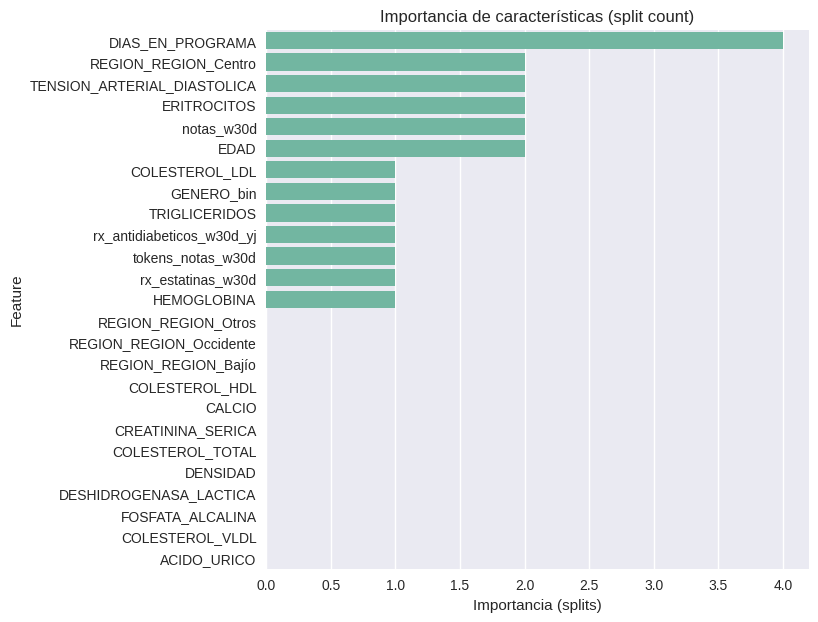

In [25]:
# =============================
# 5) IMPORTANCIAS
# =============================
# (a) Gain-based (propias de LightGBM)
imp_gain = pd.Series(lgbm.feature_importances_, index=feature_cols)  # 'split' por defecto; usa 'gain' con booster nativo
imp_tbl = imp_gain.sort_values(ascending=False).head(25)
plt.figure(figsize=(7,7))
sns.barplot(x=imp_tbl.values, y=imp_tbl.index, orient='h')
plt.title("Importancia de características (split count)")
plt.xlabel("Importancia (splits)"); plt.ylabel("Feature")
plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child

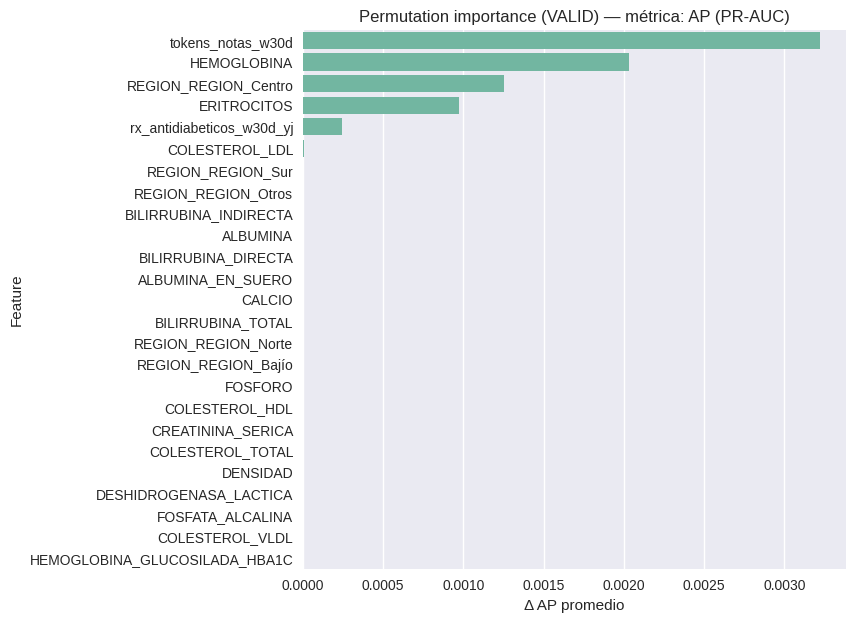

In [26]:
# (b) Permutation importance (más estable vs. fuga)
perm = permutation_importance(lgbm, Xva, yva, n_repeats=10, random_state=42, scoring="average_precision")
perm_tbl = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False).head(25)
plt.figure(figsize=(7,7))
sns.barplot(x=perm_tbl.values, y=perm_tbl.index, orient='h')
plt.title("Permutation importance (VALID) — métrica: AP (PR-AUC)")
plt.xlabel("Δ AP promedio"); plt.ylabel("Feature")
plt.show()

**Importancia de Variables**

Se evaluó la **relevancia de las variables predictoras para la hospitalización a 30 días (target_hosp_30d)** mediante dos enfoques complementarios aplicados al modelo LightGBM:

**(a) importancia basada en ganancia (gain-based)**

**(b) importancia por permutación (permutation importance)**

La **importancia basada en ganancia** refleja cuántas veces una variable fue utilizada para dividir nodos en los árboles del modelo y cuánto contribuyó a mejorar su poder predictivo.
`DIAS_EN_PROGRAMA` es la variable más influyente, indicando que el tiempo que un paciente lleva en el programa tiene fuerte relación con el riesgo de hospitalización.

Variables regionales (`REGION_REGION_Centro`, `REGION_REGION_Otros`, `REGION_REGION_Bajío`) también destacan, lo cual sugiere diferencias geográficas en los patrones de hospitalización.

Indicadores clínicos como `TENSION_ARTERIAL_DIASTOLICA`, `ERITROCITOS`, `EDAD` y `COLESTEROL_LDL` muestran influencia significativa, reflejando que los parámetros fisiológicos contribuyen al modelo.

Variables textuales (`notas_w30d`, `tokens_notas_w30d`) también aportan, confirmando que la información extraída de las notas médicas agrega valor predictivo.

La **importancia por permutación**, por su parte, evalúa la pérdida de desempeño del modelo al alterar aleatoriamente los valores de cada variable.
`tokens_notas_w30d` es la variable que más afecta la métrica cuando se altera, lo que confirma su fuerte valor predictivo semántico derivado de las notas médicas.

`HEMOGLOBINA` y `ERITROCITOS` mantienen alta relevancia clínica, sugiriendo que parámetros hematológicos están asociados con riesgo de hospitalización.

`REGION_REGION_Centro` y `rx_antidiabeticos_w30d_yj` también contribuyen, lo que reafirma la influencia tanto del contexto geográfico como del uso reciente de medicación.

Ambos enfoques coincidieron en que las variables relacionadas con el tiempo de permanencia en el programa, parámetros hematológicos y características derivadas del procesamiento semántico de notas médicas fueron determinantes en la predicción de hospitalización a 30 días, mientras que factores regionales y bioquímicos complementaron la explicación del riesgo.

In [27]:
# ----------------------------
# 6) Diagnóstico de sub/sobreajuste
#    (comparar PR-AUC/ROC-AUC/Brier y desempeño a umbral en TRAIN vs VALID)
# ----------------------------
print("\n=== Diagnóstico de ajuste (TRAIN vs VALID) ===")
delta_pr  = m_tr["PR_AUC"] - m_va["PR_AUC"]
delta_roc = m_tr["ROC_AUC"] - m_va["ROC_AUC"]
delta_bri = m_va["Brier"] - m_tr["Brier"]  # positivo -> VALID peor calibrado
print({"ΔPR_AUC(Train-Valid)": round(delta_pr,4),
       "ΔROC_AUC(Train-Valid)": round(delta_roc,4),
       "ΔBrier(Valid-Train)": round(delta_bri,4)})


=== Diagnóstico de ajuste (TRAIN vs VALID) ===
{'ΔPR_AUC(Train-Valid)': 0.1304, 'ΔROC_AUC(Train-Valid)': 0.3038, 'ΔBrier(Valid-Train)': 0.0155}


**Diagnóstico de ajuste (TRAIN vs VALID)**

**Caída de discriminación (ΔPR-AUC = 0.1304; ΔROC-AUC = 0.3038):**
La brecha entre train y valid indica pérdida sustantiva de capacidad discriminativa fuera de muestra. El descenso de PR-AUC (sensible a clases raras) sugiere que, en validación temporal, el modelo ordena peor a los verdaderos positivos en los percentiles altos; la caída marcada de ROC-AUC confirma sobreajuste y/o deriva temporal (cambios de mezcla clínica/estacionalidad y prevalencia entre meses).

**Descalibración (ΔBrier = +0.0155):** El incremento del Brier en validación evidencia probabilidades menos fieles a las frecuencias observadas; es consistente con drift y con un modelo ajustado a patrones idiosincráticos del período de entrenamiento.

**Implicación para viabilidad:** El modelo captura señal en train pero no la sostiene con datos futuros sin ajustes. Para uso operativo se recomienda: (i) validación temporal rolling/expanding, (ii) regularización más conservadora (p. ej., menos leaves, mayor min_data_in_leaf, mayor reg_lambda), (iii) re-entrenamiento y calibración mensual (isotónica/Platt), y (iv) features de recencia/delta y monitoreo de drift; con ello, se espera reducir la brecha y estabilizar desempeño en validación.

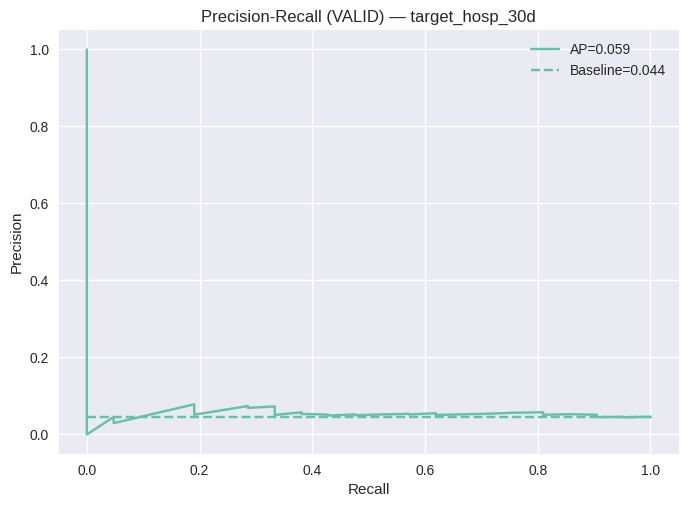

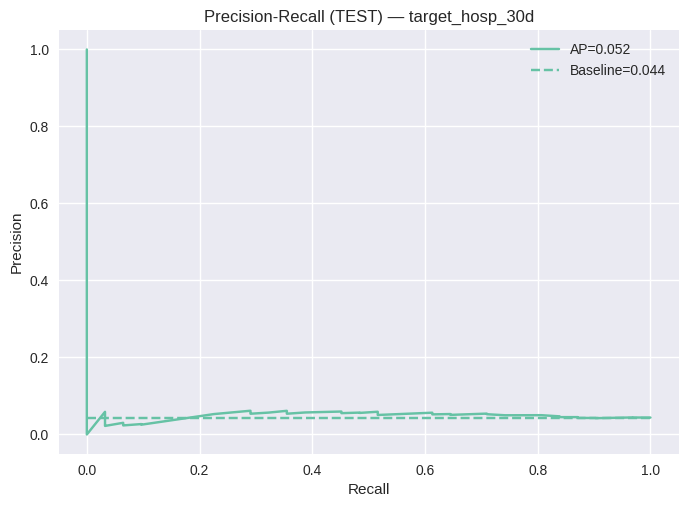

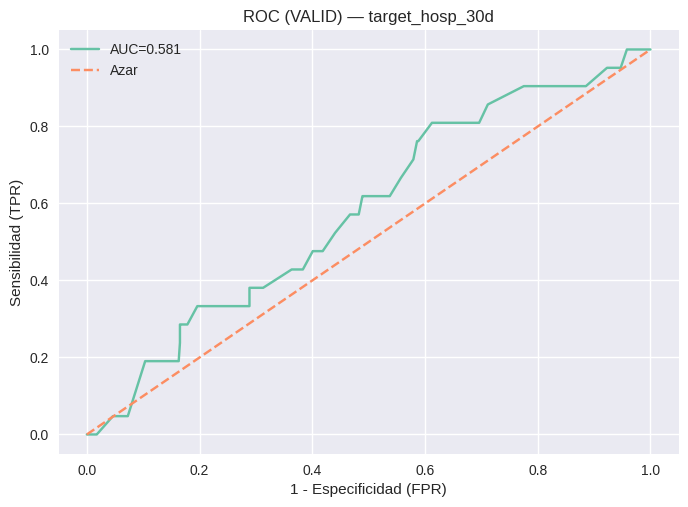

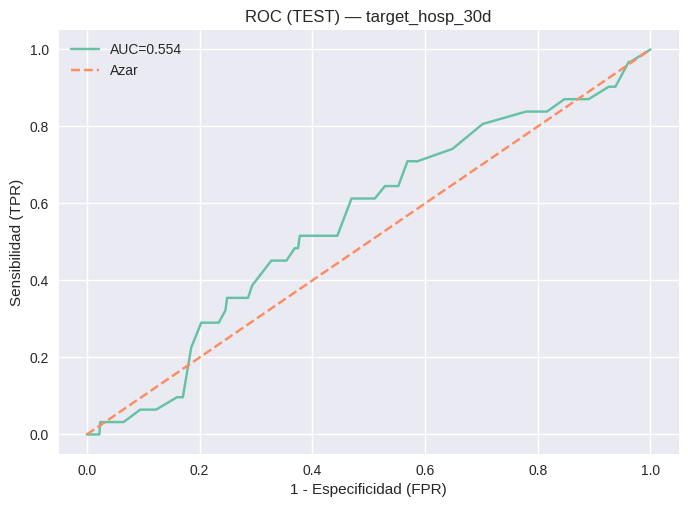

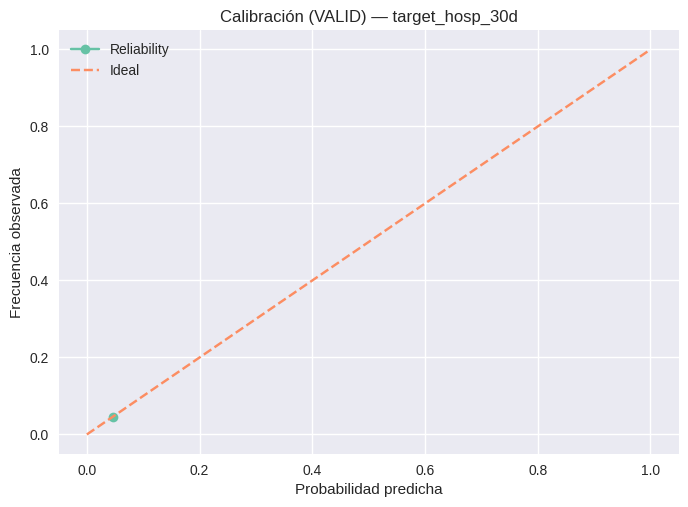

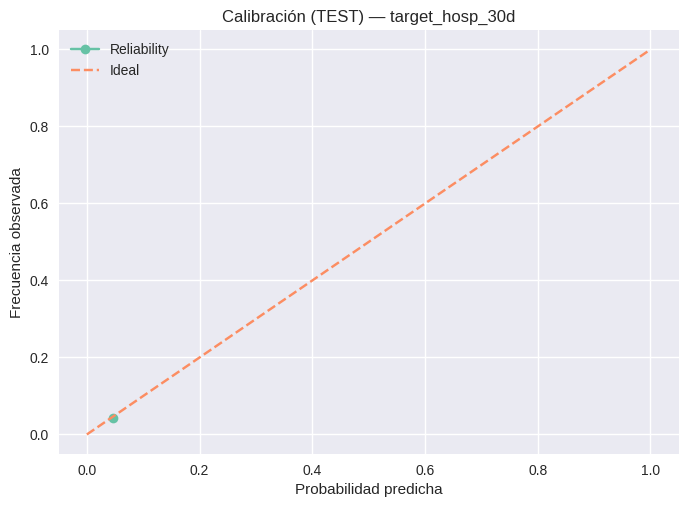

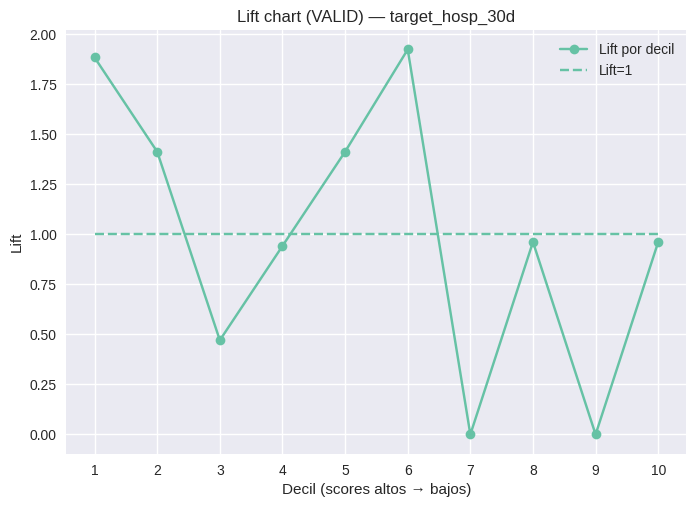

In [28]:
# ----------------------------
# Gráficas: PR, ROC, Calibración, Lift
# ----------------------------
def plot_pr_curve(y, p, title):
    pr, rc, _ = precision_recall_curve(y, p)
    ap = average_precision_score(y, p)
    plt.figure()
    plt.plot(rc, pr, label=f"AP={ap:.3f}")
    plt.hlines(y.mean(), 0, 1, linestyles='dashed', label=f"Baseline={y.mean():.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(title); plt.legend(loc="best"); plt.show()

def plot_roc_curve(y, p, title):
    try:
        auc = roc_auc_score(y, p)
    except ValueError:
        auc = np.nan
    fpr, tpr, _ = roc_curve(y, p)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1], linestyle='dashed', label="Azar")
    plt.xlabel("1 - Especificidad (FPR)"); plt.ylabel("Sensibilidad (TPR)")
    plt.title(title); plt.legend(loc="best"); plt.show()

def plot_calibration(y, p, title, n_bins=8):
    prob_true, prob_pred = calibration_curve(y, p, n_bins=n_bins, strategy='uniform')
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o', label="Reliability")
    plt.plot([0,1],[0,1], linestyle='dashed', label="Ideal")
    plt.xlabel("Probabilidad predicha"); plt.ylabel("Frecuencia observada")
    plt.title(title); plt.legend(loc="best"); plt.show()

def plot_lift(y, p, title, q=10):
    order = np.argsort(-p)
    y_sort = y[order]
    bins = np.array_split(y_sort, q)
    rates = [b.mean() for b in bins]
    base = y.mean()
    lift = [r/base if base>0 else np.nan for r in rates]
    xs = np.arange(1, q+1)
    plt.figure()
    plt.plot(xs, lift, marker='o', label="Lift por decil")
    plt.hlines(1.0, 1, q, linestyles='dashed', label="Lift=1")
    plt.xlabel("Decil (scores altos → bajos)"); plt.ylabel("Lift")
    plt.title(title); plt.xticks(xs); plt.legend(loc="best"); plt.show()

# PR y ROC
plot_pr_curve(yva, p_va, "Precision-Recall (VALID) — target_hosp_30d")
plot_pr_curve(yte, p_te, "Precision-Recall (TEST) — target_hosp_30d")
plot_roc_curve(yva, p_va, "ROC (VALID) — target_hosp_30d")
plot_roc_curve(yte, p_te, "ROC (TEST) — target_hosp_30d")

# Calibración
plot_calibration(yva, p_va, "Calibración (VALID) — target_hosp_30d", n_bins=8)
plot_calibration(yte, p_te, "Calibración (TEST) — target_hosp_30d", n_bins=8)

# Lift en VALID
plot_lift(yva, p_va, "Lift chart (VALID) — target_hosp_30d", q=10)

In [29]:
# -------------------------------------------
# Métricas mensuales por CODMES y split
# AUC, Gini (=2*AUC-1), PR_AUC y Brier
# -------------------------------------------
def monthly_metrics(df, yname, p, split_name, id_cols=("ID_EHT","FECHA_MES_5","CODMES")):
    tmp = df[list(id_cols) + [yname]].copy()
    tmp["p_hat"] = p
    rows = []
    for codmes, g in tmp.groupby("CODMES"):
        y_m = g[yname].astype(int).values
        p_m = g["p_hat"].values
        n_m = len(g)
        pos_m = int(y_m.sum())
        prev_m = y_m.mean() if n_m > 0 else np.nan

        # AUC/Gini solo si hay ambas clases
        if len(np.unique(y_m)) < 2:
            auc = np.nan
            gini = np.nan
            ap = np.nan  # PR_AUC
        else:
            auc = roc_auc_score(y_m, p_m)
            gini = 2*auc - 1.0
            ap = average_precision_score(y_m, p_m)

        # Brier siempre es calculable (probabilidades vs etiqueta binaria)
        try:
            brier = brier_score_loss(y_m, p_m)
        except Exception:
            brier = np.nan

        rows.append({
            "split": split_name,
            "CODMES": int(codmes),
            "n": int(n_m),
            "positivos": pos_m,
            "prevalencia": prev_m,
            "AUC": auc,
            "Gini": gini,
            "PR_AUC": ap,
            "Brier": brier
        })
    return pd.DataFrame(rows).sort_values("CODMES")

# --- Cálculo para cada split (usando variables/arrays ya calculados) ---
gini_tr = monthly_metrics(train, target_name, p_tr, "TRAIN", id_cols=id_cols)
gini_va = monthly_metrics(val,   target_name, p_va, "VALID", id_cols=id_cols)
gini_te = monthly_metrics(test,  target_name, p_te, "TEST",  id_cols=id_cols)

metrics_all = pd.concat([gini_tr, gini_va, gini_te], ignore_index=True)

print("\n=== Métricas mensuales por CODMES y split (AUC, Gini, PR_AUC, Brier) ===")
print(metrics_all.round(4).to_string(index=False))


=== Métricas mensuales por CODMES y split (AUC, Gini, PR_AUC, Brier) ===
split  CODMES   n  positivos  prevalencia    AUC    Gini  PR_AUC  Brier
TRAIN  202406 198          6       0.0303 0.9188  0.8377  0.4370 0.0275
TRAIN  202407 228          6       0.0263 0.9606  0.9212  0.2918 0.0241
TRAIN  202408 243          3       0.0123 0.9264  0.8528  0.0901 0.0128
TRAIN  202409 253          9       0.0356 0.8402  0.6803  0.1550 0.0331
TRAIN  202410 253          7       0.0277 0.7988  0.5976  0.0788 0.0266
TRAIN  202411 252         11       0.0437 0.9125  0.8250  0.4810 0.0393
TRAIN  202412 251          6       0.0239 0.9095  0.8190  0.3162 0.0227
VALID  202501 236         13       0.0551 0.5505  0.1011  0.0673 0.0523
VALID  202502 239          8       0.0335 0.6323  0.2646  0.0609 0.0323
 TEST  202503 244         10       0.0410 0.4318 -0.1363  0.0486 0.0400
 TEST  202504 232          5       0.0216 0.4559 -0.0881  0.0228 0.0222
 TEST  202505 230         16       0.0696 0.6888  0.3776  0.11

**Desempeño en entrenamiento (TRAIN)**

*   **Discriminación alta y estable.** AUC entre 0.80–0.96 (Gini 0.60–0.92) indica fuerte capacidad de ranking en meses vistos.
*   **Utilidad sobre el azar clara.** La PR-AUC supera ampliamente la prevalencia (p. ej., 202406: 0.437 vs 0.0303 ≈ 14×; 202411: 0.481 vs 0.0437 ≈ 11×), confirmando que el modelo concentra eventos en los percentiles altos.
*   **Calibración interna aceptable.** Brier bajo (0.013–0.039) sugiere probabilidades coherentes dentro del periodo de entrenamiento.
Lectura: hay señal predictiva sustantiva; posible ajuste al patrón de los meses entrenados.

**Validación temporal (VALID, 202501–202502)**

*   **Caída marcada de AUC.** 0.55 y 0.63 (Gini 0.10–0.26) reflejan deriva temporal: la relación entre predictores y evento cambia al pasar de 2024 a 2025.
*   **PR-AUC apenas sobre prevalencia.** 202501: 0.0673 vs 0.0551 (≈1.2×); 202502: 0.0609 vs 0.0335 (≈1.8×). La ganancia existe pero es modesta.
*   **Brier mayor.** (0.032–0.052) evidencia descalibración fuera del periodo entrenado.
Lectura: generaliza mejor que azar, pero con sensibilidad a cambios de mezcla/estacionalidad y registro.

**Conclusión de viabilidad (baseline)**

**El baseline sí aporta valor:** en validación/prueba la PR-AUC es mayor que la prevalencia (criterio mínimo), y en algunos meses la mejora es sustantiva.

No obstante, la deriva temporal y la descalibración reducen la estabilidad entre meses, por lo que el baseline lot omaremos como mínimo aceptable y punto de partida.

**3.2 Entrenamiento para las hospitalizaciones en los próximos 90 días**

In [30]:
# ----------------------------
# Entradas
# ----------------------------
train = df_mastertable_train.copy()
val   = df_mastertable_val.copy()
test  = df_mastertable_test.copy()

id_cols     = ["ID_EHT","FECHA_MES_5","CODMES"]
target_name = "target_hosp_90d"

# Variables permitidas (las que definiste)
allowed_vars = [
    "GENERO_bin",
    "REGION_REGION_Bajío","REGION_REGION_Centro","REGION_REGION_Norte",
    "REGION_REGION_Occidente","REGION_REGION_Otros","REGION_REGION_Sur",
    "ACIDO_URICO","ALBUMINA","ALBUMINA_EN_SUERO","BILIRRUBINA_DIRECTA","BILIRRUBINA_INDIRECTA",
    "BILIRRUBINA_TOTAL","CALCIO","COLESTEROL_HDL","COLESTEROL_LDL","COLESTEROL_TOTAL","COLESTEROL_VLDL",
    "CREATININA_SERICA","DENSIDAD","DESHIDROGENASA_LACTICA","ERITROCITOS","FOSFATA_ALCALINA","FOSFORO",
    "GLOBULINA","GLUCOSA_EN_SUERO_AYUNO","HEMATOCRITOS","HEMOGLOBINA","HEMOGLOBINA_GLUCOSILADA_HBA1C",
    "HIERRO","IMC","INDICE_ATEROGENICO","LEUCOCITOS_TOTALES","NITROGENO_UREICO_BUN","OXIMETRIA_CAPILAR",
    "PESO","PH","PLAQUETAS","POTASIO","PROTEINA_C_REACTIVA","PROTEINA_TOTAL","SODIO","TALLA",
    "TENSION_ARTERIAL_SISTOLICA","TRIGLICERIDOS","TENSION_ARTERIAL_DIASTOLICA",
    "DIAS_EN_PROGRAMA","EDAD",
    "rx_w30d","rx_meds_unicos_30d","rx_consultas_30d","rx_polifarmacia_30d",
    "rx_estatinas_w30d","rx_antibioticos_w30d",
    "rx_antidiabeticos_w30d_yj","rx_antihipertensivos_w30d_yj",
    "notas_w30d","tokens_notas_w30d",
    "kw_adherencia_w30d","kw_infeccion_w30d","kw_fiebre_w30d","kw_htn_w30d",
    "kw_dm_w30d_sqrt","kw_dolor_w30d_sqrt"
]
# Variables que NO debemos usar
forbidden_raw = {"rx_antihipertensivos_w30d","rx_antidiabeticos_w30d","kw_dolor_w30d","kw_dm_w30d"}
allowed_vars = [c for c in allowed_vars if c not in forbidden_raw]

# Preferir columnas escaladas *_z si existen; si no, usar el nombre original
def pick_scaled_or_raw(df, cols):
    chosen = []
    for c in cols:
        cz = f"{c}_z"
        if cz in df.columns and pd.api.types.is_numeric_dtype(df[cz]):
            chosen.append(cz)
        else:
            chosen.append(c)  # ya está numérica/codificada
    return chosen

feature_cols = pick_scaled_or_raw(train, allowed_vars)

# Verificación rápida
missing = [c for c in feature_cols if c not in train.columns]
assert len(missing) == 0, f"Faltan columnas en TRAIN: {missing}"

In [31]:
# ----------------------------
# Funciones de Utilidad
# ----------------------------
def get_xy(df, features, yname):
    X = df[features].astype(float).values
    y = df[yname].astype(int).values
    return X, y

def eval_prob_metrics(y_true, p_hat):
    return {
        "Prevalencia": float(y_true.mean()),
        "PR_AUC": float(average_precision_score(y_true, p_hat)),
        "ROC_AUC": float(roc_auc_score(y_true, p_hat)),
        "Brier": float(brier_score_loss(y_true, p_hat))
    }

def threshold_topk(y_true, p_hat, k=0.05):
    n = len(p_hat)
    k = min(max(int(np.floor(k*n)), 1), n)
    order = np.argsort(-p_hat)
    thr = p_hat[order[k-1]]
    y_pred = (p_hat >= thr).astype(int)
    tp = ((y_pred==1) & (y_true==1)).sum()
    fp = ((y_pred==1) & (y_true==0)).sum()
    fn = ((y_pred==0) & (y_true==1)).sum()
    prec = tp / (tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp / (tp+fn) if (tp+fn)>0 else 0.0
    return thr, {"alerts_rate": k/len(p_hat), "Precision@k": prec, "Recall@k": rec}

def threshold_max_f1(y_true, p_hat):
    pr, rc, th = precision_recall_curve(y_true, p_hat)
    f1 = 2*pr*rc / (pr+rc + 1e-12)
    j = int(np.nanargmax(f1))
    thr = th[j-1] if j>0 and j-1 < len(th) else 0.5  # manejo de bordes
    return float(thr), {"F1_max": float(f1[j]), "Precision_at_F1": float(pr[j]), "Recall_at_F1": float(rc[j])}

def eval_at_threshold(y, p, thr):
    yhat = (p >= thr).astype(int)
    tp = ((yhat==1)&(y==1)).sum(); fp = ((yhat==1)&(y==0)).sum()
    fn = ((yhat==0)&(y==1)).sum(); tn = ((yhat==0)&(y==0)).sum()
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    return {"TP":tp, "FP":fp, "FN":fn, "TN":tn, "Precision":prec, "Recall":rec, "AlertsRate": yhat.mean()}

In [32]:
# =============================
# 1) DATA -> matrices
# =============================
Xtr, ytr = get_xy(train, feature_cols, target_name)
Xva, yva = get_xy(val,   feature_cols, target_name)
Xte, yte = get_xy(test,  feature_cols, target_name)

print(f"Shapes -> Xtr:{Xtr.shape}, Xva:{Xva.shape}, Xte:{Xte.shape}")
print(f"Prevalencias -> Train:{ytr.mean():.4f}  Val:{yva.mean():.4f}  Test:{yte.mean():.4f}")

# Peso de clase (solo con TRAIN)
pos = ytr.sum(); neg = len(ytr) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print(f"scale_pos_weight (train): {scale_pos_weight:.2f}")

Shapes -> Xtr:(1678, 64), Xva:(475, 64), Xte:(706, 64)
Prevalencias -> Train:0.0882  Val:0.1074  Test:0.1558
scale_pos_weight (train): 10.34


In [33]:
# =============================
# 2) MODELO: LightGBM (GBDT)
# =============================
lgbm = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_estimators=4000,           # con early_stopping
    learning_rate=0.03,
    num_leaves=31, #63,               # 31-127 típico (ajustable)
    min_data_in_leaf=100, #60,         # regulariza
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    reg_lambda=2.0, #1.0,              # L2
    reg_alpha=0.0,               # L1 si hace falta
    scale_pos_weight=scale_pos_weight,   # manejo desbalance
    n_jobs=-1,
    random_state=42
)

lgbm.fit(
    Xtr, ytr,
    eval_set=[(Xva, yva)],
    eval_names=["valid"],
    eval_metric=["auc","average_precision"],  # PR-AUC es average_precision en lgb
    callbacks=[
        lgb.early_stopping(stopping_rounds=300, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

# Probabilidades
p_tr = lgbm.predict_proba(Xtr, num_iteration=lgbm.best_iteration_)[:,1]
p_va = lgbm.predict_proba(Xva, num_iteration=lgbm.best_iteration_)[:,1]
p_te = lgbm.predict_proba(Xte, num_iteration=lgbm.best_iteration_)[:,1]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 148, number of n

In [34]:
# =============================
# 3) MÉTRICAS (probabilísticas)
# =============================
m_tr = eval_prob_metrics(ytr, p_tr)
m_va = eval_prob_metrics(yva, p_va)
m_te = eval_prob_metrics(yte, p_te)

print("\n=== Métricas probabilísticas (LightGBM) ===")
print("[TRAIN]", {k: round(v,4) for k,v in m_tr.items()})
print("[VALID]", {k: round(v,4) for k,v in m_va.items()})
print("[TEST ]", {k: round(v,4) for k,v in m_te.items()})


=== Métricas probabilísticas (LightGBM) ===
[TRAIN] {'Prevalencia': 0.0882, 'PR_AUC': 0.3264, 'ROC_AUC': 0.8279, 'Brier': 0.0781}
[VALID] {'Prevalencia': 0.1074, 'PR_AUC': 0.1816, 'ROC_AUC': 0.6242, 'Brier': 0.0949}
[TEST ] {'Prevalencia': 0.1558, 'PR_AUC': 0.2712, 'ROC_AUC': 0.6257, 'Brier': 0.1304}


In [35]:
# =============================
# 4) SELECCIÓN DE UMBRAL (en VALID)
# =============================
thr_k,  kstats_va  = threshold_topk(yva, p_va, k=0.05)  # top-5%
thr_f1, f1stats_va = threshold_max_f1(yva, p_va)

print("\nUmbrales en VALID:")
print(f"- top-5%: thr={thr_k:.4f}, stats={ {k: round(v,4) for k,v in kstats_va.items()} }")
print(f"- F1 max: thr={thr_f1:.4f}, stats={ {k: round(v,4) for k,v in f1stats_va.items()} }")

chosen_thr = thr_k  # o thr_f1 según operación

# Evalúa en TRAIN/TEST con ese umbral
at_tr = eval_at_threshold(ytr, p_tr, chosen_thr)
at_va = eval_at_threshold(yva, p_va, chosen_thr)
at_te = eval_at_threshold(yte, p_te, chosen_thr)

print("\n=== Desempeño a umbral elegido ===")
print("[TRAIN]", {k: (round(v,4) if isinstance(v,float) else v) for k,v in at_tr.items()})
print("[VALID]", {k: (round(v,4) if isinstance(v,float) else v) for k,v in at_va.items()})
print("[TEST ]", {k: (round(v,4) if isinstance(v,float) else v) for k,v in at_te.items()})


Umbrales en VALID:
- top-5%: thr=0.1589, stats={'alerts_rate': 0.0484, 'Precision@k': np.float64(0.2609), 'Recall@k': np.float64(0.1176)}
- F1 max: thr=0.1269, stats={'F1_max': 0.2646, 'Precision_at_F1': 0.165, 'Recall_at_F1': 0.6667}

=== Desempeño a umbral elegido ===
[TRAIN] {'TP': np.int64(28), 'FP': np.int64(27), 'FN': np.int64(120), 'TN': np.int64(1503), 'Precision': np.float64(0.5091), 'Recall': np.float64(0.1892), 'AlertsRate': np.float64(0.0328)}
[VALID] {'TP': np.int64(6), 'FP': np.int64(17), 'FN': np.int64(45), 'TN': np.int64(407), 'Precision': np.float64(0.2609), 'Recall': np.float64(0.1176), 'AlertsRate': np.float64(0.0484)}
[TEST ] {'TP': np.int64(14), 'FP': np.int64(21), 'FN': np.int64(96), 'TN': np.int64(575), 'Precision': np.float64(0.4), 'Recall': np.float64(0.1273), 'AlertsRate': np.float64(0.0496)}


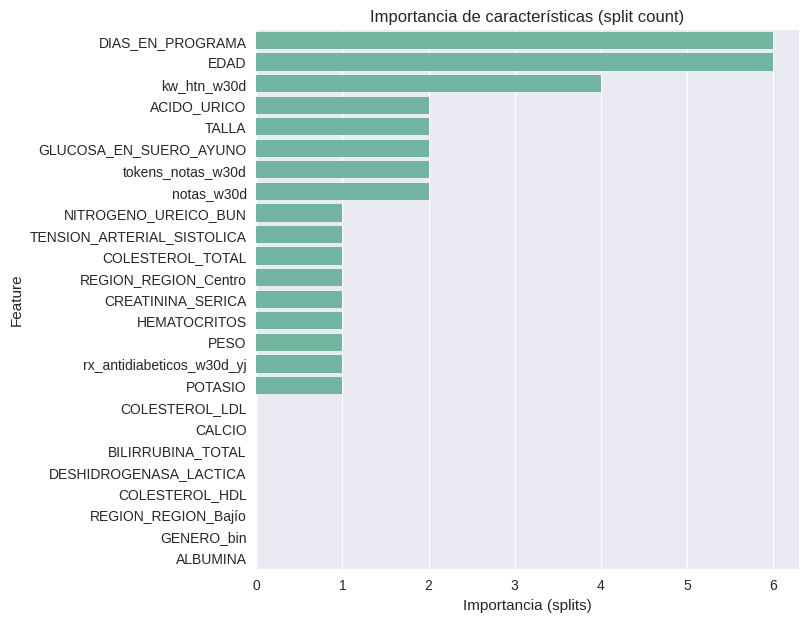

In [36]:
# =============================
# 5) IMPORTANCIAS
# =============================
# (a) Gain-based (propias de LightGBM)
imp_gain = pd.Series(lgbm.feature_importances_, index=feature_cols)  # 'split' por defecto; usa 'gain' con booster nativo
imp_tbl = imp_gain.sort_values(ascending=False).head(25)
plt.figure(figsize=(7,7))
sns.barplot(x=imp_tbl.values, y=imp_tbl.index, orient='h')
plt.title("Importancia de características (split count)")
plt.xlabel("Importancia (splits)"); plt.ylabel("Feature")
plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_

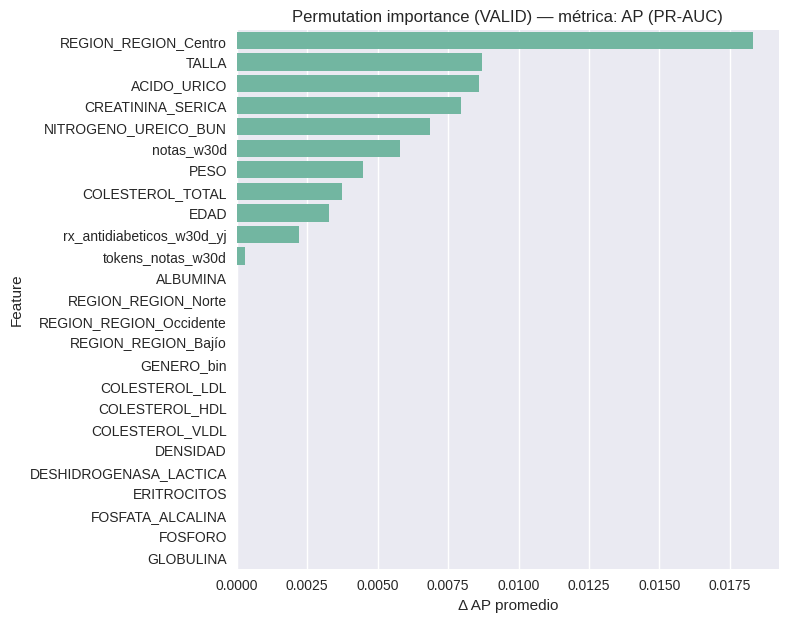

In [37]:
# (b) Permutation importance (más estable vs. fuga)
perm = permutation_importance(lgbm, Xva, yva, n_repeats=10, random_state=42, scoring="average_precision")
perm_tbl = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False).head(25)
plt.figure(figsize=(7,7))
sns.barplot(x=perm_tbl.values, y=perm_tbl.index, orient='h')
plt.title("Permutation importance (VALID) — métrica: AP (PR-AUC)")
plt.xlabel("Δ AP promedio"); plt.ylabel("Feature")
plt.show()

In [38]:
# ----------------------------
# 6) Diagnóstico de sub/sobreajuste
#    (comparar PR-AUC/ROC-AUC/Brier y desempeño a umbral en TRAIN vs VALID)
# ----------------------------
print("\n=== Diagnóstico de ajuste (TRAIN vs VALID) ===")
delta_pr  = m_tr["PR_AUC"] - m_va["PR_AUC"]
delta_roc = m_tr["ROC_AUC"] - m_va["ROC_AUC"]
delta_bri = m_va["Brier"] - m_tr["Brier"]  # positivo -> VALID peor calibrado
print({"ΔPR_AUC(Train-Valid)": round(delta_pr,4),
       "ΔROC_AUC(Train-Valid)": round(delta_roc,4),
       "ΔBrier(Valid-Train)": round(delta_bri,4)})


=== Diagnóstico de ajuste (TRAIN vs VALID) ===
{'ΔPR_AUC(Train-Valid)': 0.1448, 'ΔROC_AUC(Train-Valid)': 0.2038, 'ΔBrier(Valid-Train)': 0.0168}


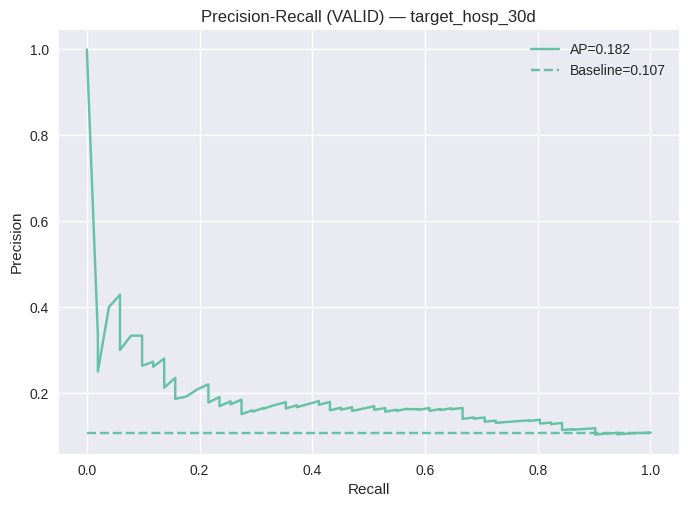

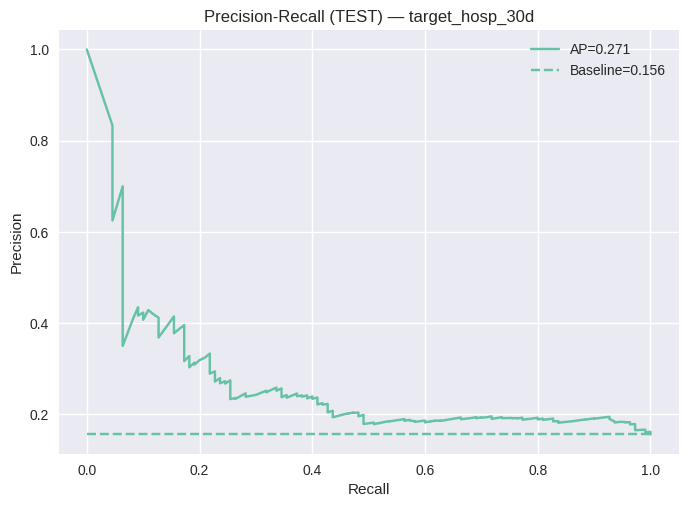

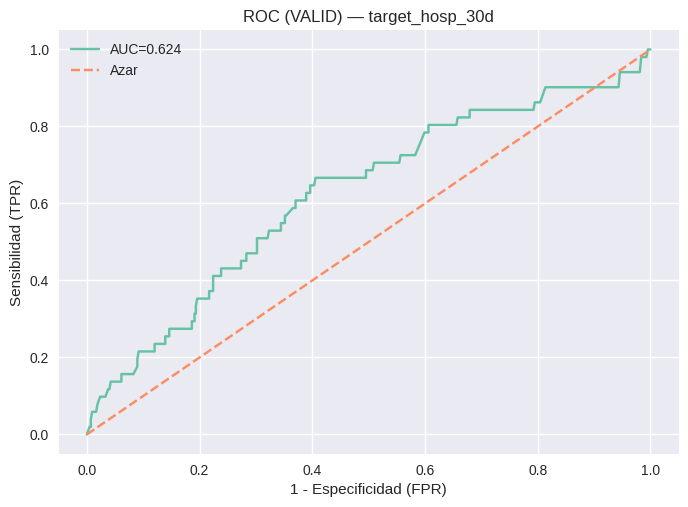

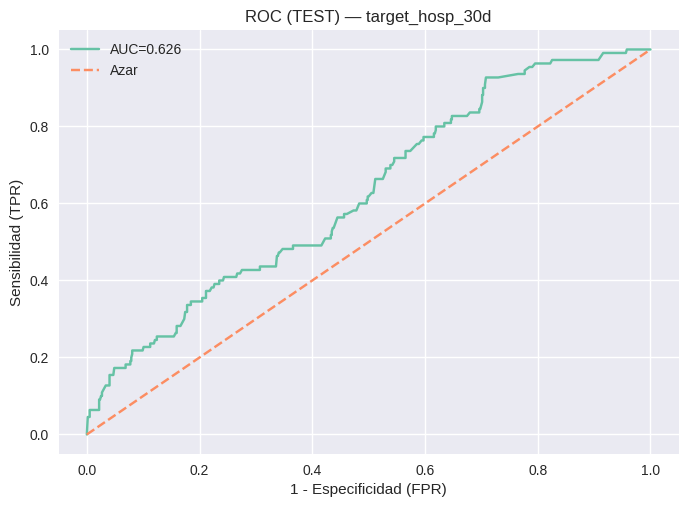

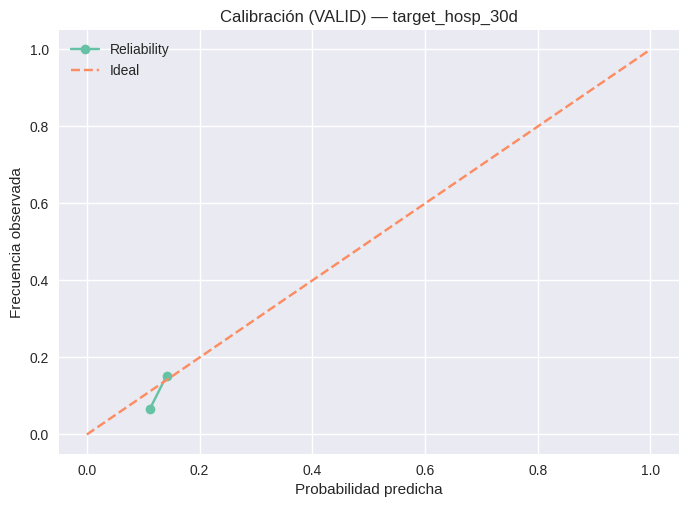

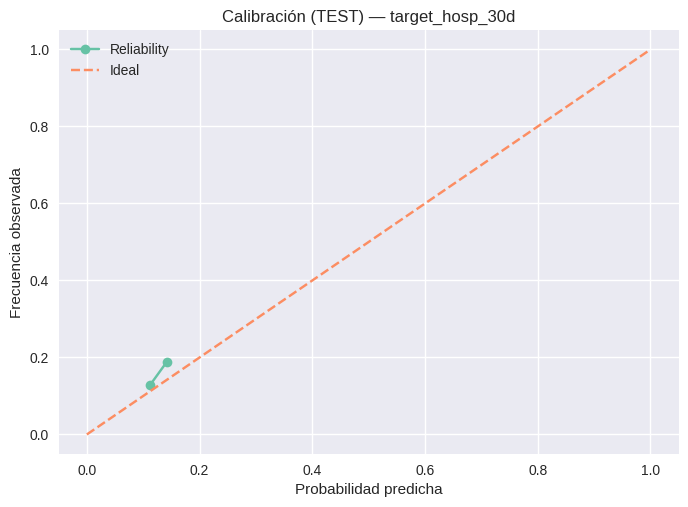

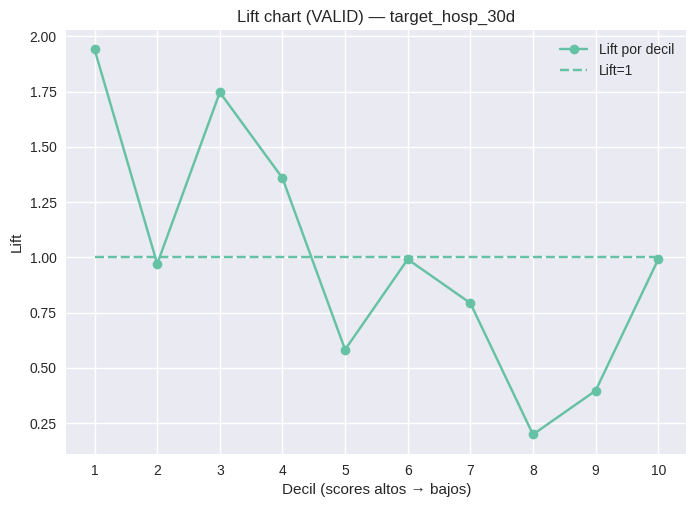

In [39]:
# ----------------------------
# Gráficas: PR, ROC, Calibración, Lift
# ----------------------------
def plot_pr_curve(y, p, title):
    pr, rc, _ = precision_recall_curve(y, p)
    ap = average_precision_score(y, p)
    plt.figure()
    plt.plot(rc, pr, label=f"AP={ap:.3f}")
    plt.hlines(y.mean(), 0, 1, linestyles='dashed', label=f"Baseline={y.mean():.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(title); plt.legend(loc="best"); plt.show()

def plot_roc_curve(y, p, title):
    try:
        auc = roc_auc_score(y, p)
    except ValueError:
        auc = np.nan
    fpr, tpr, _ = roc_curve(y, p)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1], linestyle='dashed', label="Azar")
    plt.xlabel("1 - Especificidad (FPR)"); plt.ylabel("Sensibilidad (TPR)")
    plt.title(title); plt.legend(loc="best"); plt.show()

def plot_calibration(y, p, title, n_bins=8):
    prob_true, prob_pred = calibration_curve(y, p, n_bins=n_bins, strategy='uniform')
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o', label="Reliability")
    plt.plot([0,1],[0,1], linestyle='dashed', label="Ideal")
    plt.xlabel("Probabilidad predicha"); plt.ylabel("Frecuencia observada")
    plt.title(title); plt.legend(loc="best"); plt.show()

def plot_lift(y, p, title, q=10):
    order = np.argsort(-p)
    y_sort = y[order]
    bins = np.array_split(y_sort, q)
    rates = [b.mean() for b in bins]
    base = y.mean()
    lift = [r/base if base>0 else np.nan for r in rates]
    xs = np.arange(1, q+1)
    plt.figure()
    plt.plot(xs, lift, marker='o', label="Lift por decil")
    plt.hlines(1.0, 1, q, linestyles='dashed', label="Lift=1")
    plt.xlabel("Decil (scores altos → bajos)"); plt.ylabel("Lift")
    plt.title(title); plt.xticks(xs); plt.legend(loc="best"); plt.show()

# PR y ROC
plot_pr_curve(yva, p_va, "Precision-Recall (VALID) — target_hosp_30d")
plot_pr_curve(yte, p_te, "Precision-Recall (TEST) — target_hosp_30d")
plot_roc_curve(yva, p_va, "ROC (VALID) — target_hosp_30d")
plot_roc_curve(yte, p_te, "ROC (TEST) — target_hosp_30d")

# Calibración
plot_calibration(yva, p_va, "Calibración (VALID) — target_hosp_30d", n_bins=8)
plot_calibration(yte, p_te, "Calibración (TEST) — target_hosp_30d", n_bins=8)

# Lift en VALID
plot_lift(yva, p_va, "Lift chart (VALID) — target_hosp_30d", q=10)

In [40]:
# -------------------------------------------
# Métricas mensuales por CODMES y split
# AUC, Gini (=2*AUC-1), PR_AUC y Brier
# -------------------------------------------
def monthly_metrics(df, yname, p, split_name, id_cols=("ID_EHT","FECHA_MES_5","CODMES")):
    tmp = df[list(id_cols) + [yname]].copy()
    tmp["p_hat"] = p
    rows = []
    for codmes, g in tmp.groupby("CODMES"):
        y_m = g[yname].astype(int).values
        p_m = g["p_hat"].values
        n_m = len(g)
        pos_m = int(y_m.sum())
        prev_m = y_m.mean() if n_m > 0 else np.nan

        # AUC/Gini solo si hay ambas clases
        if len(np.unique(y_m)) < 2:
            auc = np.nan
            gini = np.nan
            ap = np.nan  # PR_AUC
        else:
            auc = roc_auc_score(y_m, p_m)
            gini = 2*auc - 1.0
            ap = average_precision_score(y_m, p_m)

        # Brier siempre es calculable (probabilidades vs etiqueta binaria)
        try:
            brier = brier_score_loss(y_m, p_m)
        except Exception:
            brier = np.nan

        rows.append({
            "split": split_name,
            "CODMES": int(codmes),
            "n": int(n_m),
            "positivos": pos_m,
            "prevalencia": prev_m,
            "AUC": auc,
            "Gini": gini,
            "PR_AUC": ap,
            "Brier": brier
        })
    return pd.DataFrame(rows).sort_values("CODMES")

# --- Cálculo para cada split (usando variables/arrays ya calculados) ---
gini_tr = monthly_metrics(train, target_name, p_tr, "TRAIN", id_cols=id_cols)
gini_va = monthly_metrics(val,   target_name, p_va, "VALID", id_cols=id_cols)
gini_te = monthly_metrics(test,  target_name, p_te, "TEST",  id_cols=id_cols)

metrics_all = pd.concat([gini_tr, gini_va, gini_te], ignore_index=True)

print("\n=== Métricas mensuales por CODMES y split (AUC, Gini, PR_AUC, Brier) ===")
print(metrics_all.round(4).to_string(index=False))


=== Métricas mensuales por CODMES y split (AUC, Gini, PR_AUC, Brier) ===
split  CODMES   n  positivos  prevalencia    AUC   Gini  PR_AUC  Brier
TRAIN  202406 198         15       0.0758 0.8474 0.6947  0.3560 0.0688
TRAIN  202407 228         16       0.0702 0.8019 0.6038  0.3152 0.0657
TRAIN  202408 243         17       0.0700 0.7625 0.5250  0.2161 0.0655
TRAIN  202409 253         24       0.0949 0.8298 0.6596  0.4070 0.0827
TRAIN  202410 253         22       0.0870 0.8652 0.7304  0.3463 0.0767
TRAIN  202411 252         28       0.1111 0.8355 0.6711  0.3606 0.0947
TRAIN  202412 251         26       0.1036 0.8294 0.6588  0.3864 0.0892
VALID  202501 236         30       0.1271 0.6324 0.2647  0.2134 0.1094
VALID  202502 239         21       0.0879 0.6075 0.2149  0.1706 0.0806
 TEST  202503 244         29       0.1189 0.5787 0.1575  0.1923 0.1039
 TEST  202504 232         37       0.1595 0.6496 0.2992  0.3191 0.1327
 TEST  202505 230         44       0.1913 0.6386 0.2772  0.3350 0.1563
